In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
from pynhd import NHDPlusHR, NHD
import pynhd as nhd
from shapely.geometry import box
from shapely.ops import unary_union
import ee
import geemap
import contextily as cx

mpl.rcParams['pdf.fonttype'] = 42


In [2]:
states = geopandas.read_file("../data/mapping/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")
states = states.to_crs(epsg=4269)
st = ["Idaho"]
states = states[states["NAME"].isin(st)]

In [3]:
s_type = {46000: 'perennial',
             46006:'perennial',
          46003: 'non-perennial' ,
          46007: 'non-perennial'}

import fiona
id = geopandas.read_file('../data/mapping/ID_NHD/NHDFlowline_0.shp'
    # include_fields=["ftype","fcode", "geometry",''],
)

id = id[(id["fcode"]<=46007) & (id["ftype"]==460)]
id['stype']=id['fcode'].map(s_type)

id = geopandas.clip(id, states)

In [4]:
wa = geopandas.read_file('../data/mapping/WA_NHD/Washington_NHD.shp',
    include_fields=["fcode", "geometry"],
)

wa['stype']=wa['fcode'].map(s_type)

In [5]:
ore = geopandas.read_file('../data/mapping/OR_NHD/Oregon_NHD.shp',
    include_fields=["fcode", "geometry"],
)

ore['stype']=ore['fcode'].map(s_type)

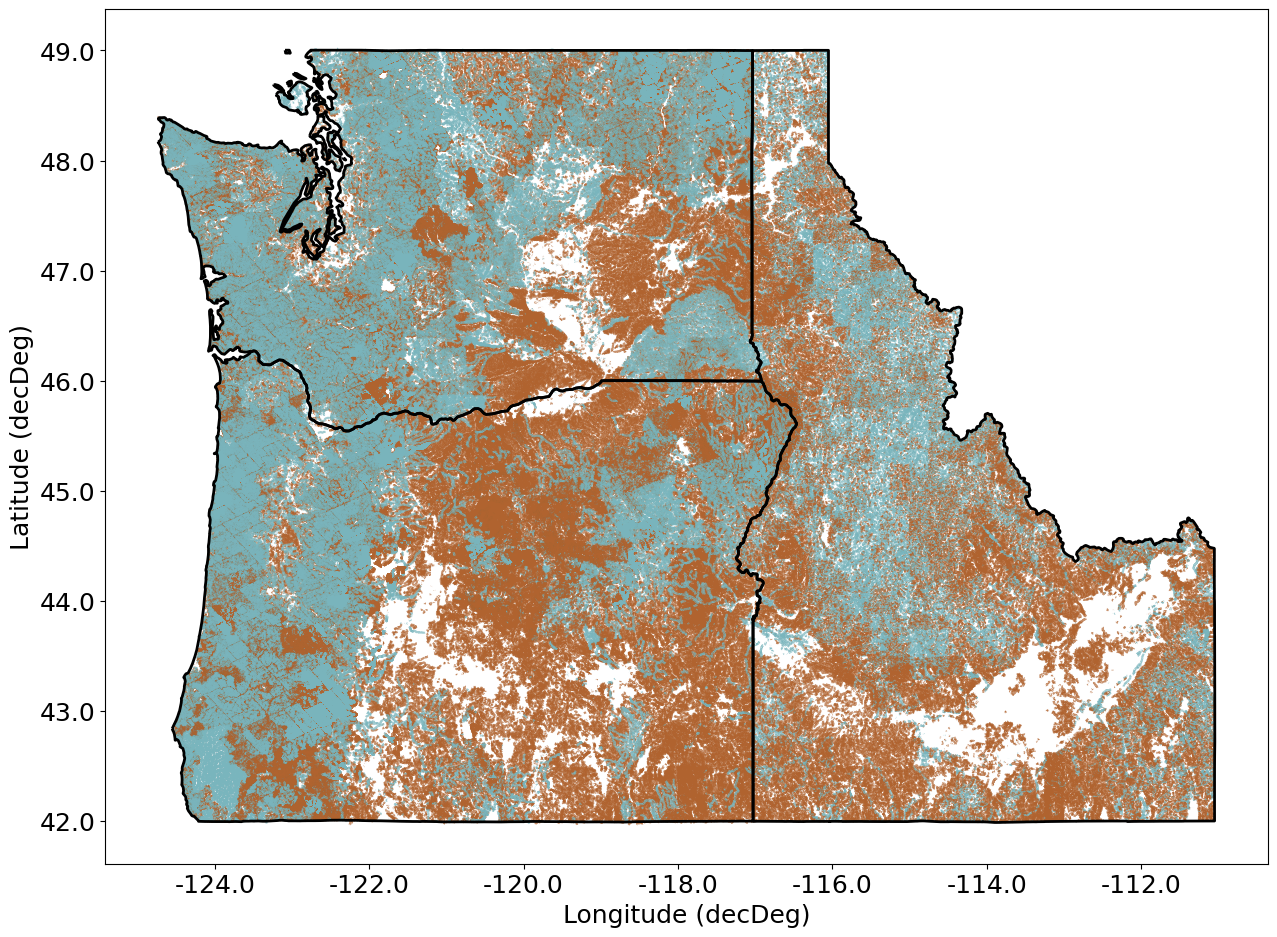

In [31]:
states = geopandas.read_file("../data/mapping/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")
states = states.to_crs(epsg=4269)
st = ["Idaho","Washington","Oregon"]
states = states[states["NAME"].isin(st)]


f,ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 18})

color_map = {'perennial': '#79B5BD',
          'non-perennial': '#B0632F'}

id.plot(ax=ax,legend=True,
        color = id['stype'].map(color_map),
       alpha = 0.7)
wa.plot(ax=ax,legend=True,
        color = wa['stype'].map(color_map),
       alpha = 0.7)
ore.plot(ax=ax,legend=True,
         color = ore['stype'].map(color_map),
       alpha = 0.7)

states.plot(ax=ax,
            facecolor="none",
            edgecolor = "black",
           linewidth = 2,
           zorder=100)



ax.set_xlabel("Longitude (decDeg)")
ax.set_ylabel("Latitude (decDeg)")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.savefig('../docs/PNW_NP_NHDhr.png',dpi=300)

## Brute force calcs

In [11]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AeaYSHA2kh6T2I4_PJ_MxMEJW6_JdjKjk7KF0aMhS89PKbU7bBi-LjC-wB0



Successfully saved authorization token.


In [12]:
m = geemap.Map()


# Get state geos to clip flowlines with
WAgeometry = ee.FeatureCollection("TIGER/2016/States").filter('STUSPS=="WA"')
ORgeometry = ee.FeatureCollection("TIGER/2016/States").filter('STUSPS=="OR"')
# m.centerObject(ORgeometry,5)


#Add NHD Flowline
fcode_vals = ee.Filter.inList('fcode',[46000,46006,46003,46007])
OR = ee.FeatureCollection('projects/sat-io/open-datasets/NHD/NHD_OR/NHDFlowline').filter(fcode_vals).filterBounds(ORgeometry.geometry())
WA = ee.FeatureCollection('projects/sat-io/open-datasets/NHD/NHD_WA/NHDFlowline').filter(fcode_vals).filterBounds(WAgeometry.geometry())


In [13]:
OR = ee.FeatureCollection('projects/sat-io/open-datasets/NHD/NHD_OR/NHDFlowline').filter('fcode==46000')
OR.aggregate_sum('lengthkm')

In [14]:
OR = ee.FeatureCollection('projects/sat-io/open-datasets/NHD/NHD_OR/NHDFlowline').filter('fcode==46006')
OR.aggregate_sum('lengthkm')

In [6]:
OR = ee.FeatureCollection('projects/sat-io/open-datasets/NHD/NHD_OR/NHDFlowline').filter('fcode==46003')
OR.aggregate_sum('lengthkm')

In [7]:
OR = ee.FeatureCollection('projects/sat-io/open-datasets/NHD/NHD_OR/NHDFlowline').filter('fcode==46007')
OR.aggregate_sum('lengthkm')

In [18]:
OR_total = 6351 + 148985 + 387613 + 55157
OR_total

598106

In [9]:
WA = ee.FeatureCollection('projects/sat-io/open-datasets/NHD/NHD_WA/NHDFlowline').filter('fcode==46000')
WA.aggregate_sum('lengthkm')

In [10]:
WA = ee.FeatureCollection('projects/sat-io/open-datasets/NHD/NHD_WA/NHDFlowline').filter('fcode==46006')
WA.aggregate_sum('lengthkm')

In [11]:
WA = ee.FeatureCollection('projects/sat-io/open-datasets/NHD/NHD_WA/NHDFlowline').filter('fcode==46003')
WA.aggregate_sum('lengthkm')

In [12]:
WA = ee.FeatureCollection('projects/sat-io/open-datasets/NHD/NHD_WA/NHDFlowline').filter('fcode==46007')
WA.aggregate_sum('lengthkm')

In [19]:
WA_total = 67174 + 124857 + 276085 + 3976
WA_total

472092

In [15]:
id_p = id['lengthkm'][id['stype']=="perennial"].sum()
id_np = id['lengthkm'][id['stype']=="non-perennial"].sum()

In [16]:
ID_total = id_p + id_np
ID_total

219424.72349463997

# Plotting

In [20]:
NP_total = id_np + 276085 + 3976 + 387613 + 55157
P_total = id_p + 67174 + 124857 + 6351 + 148985
all_total = OR_total + WA_total + ID_total

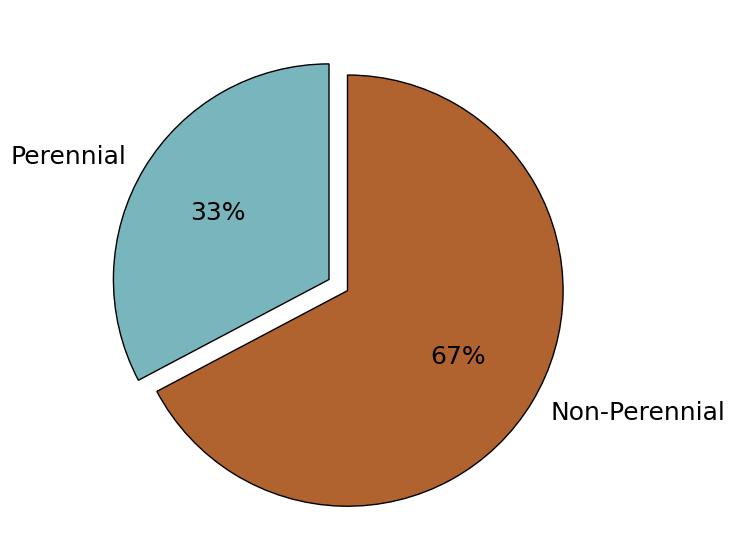

In [30]:
f,ax = plt.subplots(figsize=(10, 7))

labels = ["Perennial","Non-Perennial"]
sizes = [(P_total/all_total)*100,(NP_total/all_total)*100]

plt.rcParams.update({'font.size': 18})
colors = ['#79B5BD', '#B0632F']
explode = (0, 0.1)
plt.pie(sizes,
        startangle=90, 
        colors=colors, 
        wedgeprops={'edgecolor': 'black'}, 
        autopct='%1.f%%', 
        explode=explode,
        labels = labels)

plt.savefig('../docs/PNW_Pie.png',dpi=600)

## Export GEE to Drive

In [69]:
task1 = ee.batch.Export.table.toDrive(collection=OR, folder='data_earth_engine/OR', description='Oregon_NHD', fileFormat='SHP')
task1.start()

In [70]:
task2 = ee.batch.Export.table.toDrive(collection=WA, folder='data_earth_engine/WA', description='Washington_NHD', fileFormat='SHP')
task2.start()

In [72]:
task3 = ee.batch.Export.table.toDrive(collection=ID, folder='data_earth_engine/ID', description='Idaho_NHD', fileFormat='SHP')
task3.start()

# archive

In [ ]:
# nhdp_hrNP = nhdp_hr[(nhdp_hr["fcode"]<=46007) & (nhdp_hr["ftype"]==460)]
# s_type = {46000: 'perennial',
#              46006:'perennial',
#           46003: 'non-perennial' ,
#           46007: 'non-perennial'}

In [ ]:
walwatNP = geopandas.clip(nhdp_hrNP, walwat)

In [ ]:
f,ax = plt.subplots(figsize=(15, 15))

walwatNP_repro = walwatNP.to_crs(epsg=3857)
walwat_repro = walwat.to_crs(epsg=3857)

# walwatNP.plot(ax=ax,alpha = 0.5,color = walwatNP['stype'].map(color_map))
# walwat.plot(ax=ax,edgecolor="black",facecolor="none")

# plt.rcParams.update({'font.size': 18})
# ax.set_xlabel("Longitude (decDeg)")
# ax.set_ylabel("Latitude (decDeg)")
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# starkey_repro = starkey.to_crs(epsg=3857)

plt.rcParams.update({'font.size': 18})

color_map = {'perennial': 'blue',
          'non-perennial': 'green'}

walwatNP_repro.plot(ax=ax,legend=True,color = walwatNP_repro['stype'].map(color_map))


ax.arrow(-13220000, 5785000, 0, 20000, length_includes_head=True,
          head_width=5000, head_length=10000, overhang=.25, facecolor='k')
ax.text(x=-13224500, y=5775000, s='N', fontsize=30)
ax.set_xlabel("UTM Easting (m)")
ax.set_ylabel("UTM Northing (m)")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.locator_params(axis='y', nbins=6)
plt.locator_params(axis='x', nbins=4)
cx.add_basemap(ax ,reset_extent= False,zoom=12,source=cx.providers.USGS.USTopo)
plt.savefig('../docs/wilwit_NPmap.png',dpi=300)

In [ ]:
f,ax = plt.subplots(figsize=(7, 7))
# sns.countplot(walwatNP['stype'],
#               palette=color_map)


walwatNP_count = walwatNP.groupby(['stype'])['lengthkm'].agg('sum').to_frame()
plt.rcParams.update({'font.size': 18})
colors = ['green', 'blue']
explode = (0, 0.1)
plt.pie(walwatNP_count['lengthkm'], 
        startangle=90, 
        colors=colors, 
        wedgeprops={'edgecolor': 'black'}, 
        autopct='%1.f%%', 
        explode=explode,
        labels = walwatNP_count.index)

plt.savefig('../docs/wilwit_NPpie.png',dpi=600,bbox_inches = "tight")